In [4]:
import pandas as pd
import numpy as np
import joblib

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [5]:
X_train = joblib.load('../../preprocessed_data/InSDN/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/InSDN/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/InSDN/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/InSDN/Y_test.joblib')

### CNN training

In [6]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.5), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 65, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9692 - loss: 0.1284 - val_accuracy: 0.9913 - val_loss: 0.0360
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9911 - loss: 0.0362 - val_accuracy: 0.9918 - val_loss: 0.0301
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9908 - loss: 0.0351 - val_accuracy: 0.9916 - val_loss: 0.0287
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9916 - loss: 0.0322 - val_accuracy: 0.9920 - val_loss: 0.0268
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9920 - loss: 0.0295 - val_accuracy: 0.9921 - val_loss: 0.0272


### LSTM training

In [7]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9226 - loss: 0.2044 - val_accuracy: 0.9862 - val_loss: 0.0568
Epoch 2/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9883 - loss: 0.0461 - val_accuracy: 0.9908 - val_loss: 0.0395
Epoch 3/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9904 - loss: 0.0382 - val_accuracy: 0.9903 - val_loss: 0.0388


### AE-LSTM

In [8]:
input_dim = X_train.shape[1]  # n_features

# encoder (will shrink the input data making it more compact from 64 to 32 features)
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x) # decode the input 64 features again
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 67, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,153 (82.63 KB)

 Trainable params: 21,153 (82.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9275 - loss: 0.1972 - val_accuracy: 0.9898 - val_loss: 0.0413
Epoch 2/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9868 - loss: 0.0490 - val_accuracy: 0.9772 - val_loss: 0.0629
Epoch 3/3
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9907 - loss: 0.0390 - val_accuracy: 0.9913 - val_loss: 0.0348


Let's save our models

In [9]:
CNN_model.save("../../models/cnn_insdn_model.keras")
LSTM_model.save("../../models/lstm_insdn_model.keras")
AE_LSTM_model.save("../../models/ae-lstm_insdn_model.keras")

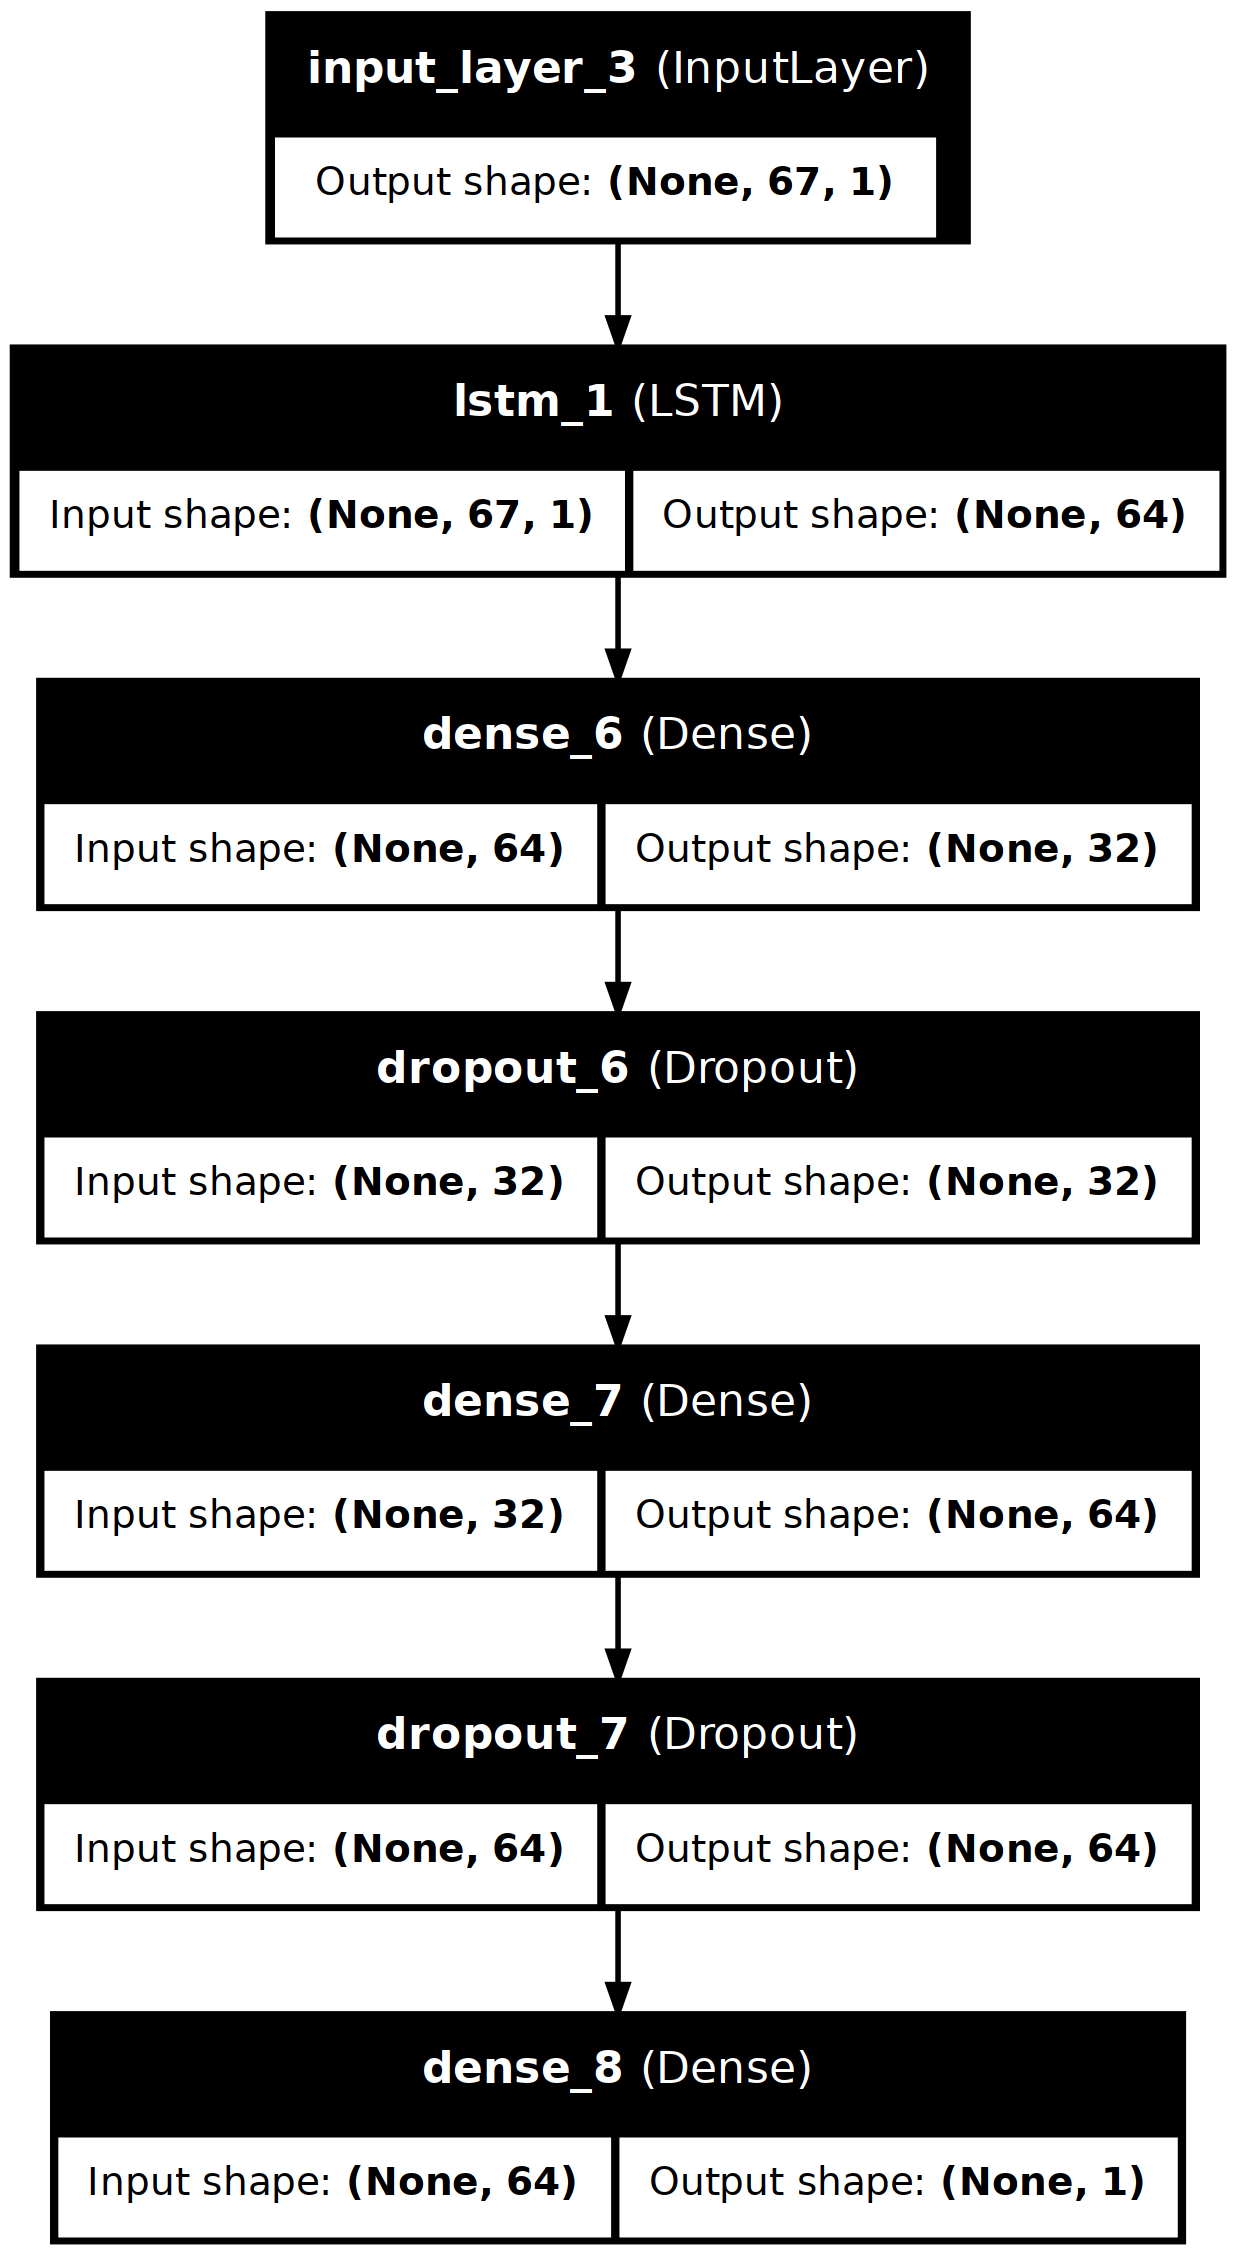

In [10]:
from tensorflow.keras.utils import plot_model
from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_insdn_model.keras')
lstm_loaded = load_model('../../models/lstm_insdn_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_insdn_model.keras')

plot_model(cnn_loaded, to_file='../../results/InSDN/models/CNN_model.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_loaded, to_file='../../results/InSDN/models/LSTM_model.png', show_shapes=True, show_layer_names=True)
plot_model(ae_lstm_loaded, to_file='../../results/InSDN/models/AE-LSTM_model.png', show_shapes=True, show_layer_names=True)

### CNN metrics

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0272
Test Accuracy: 0.9921


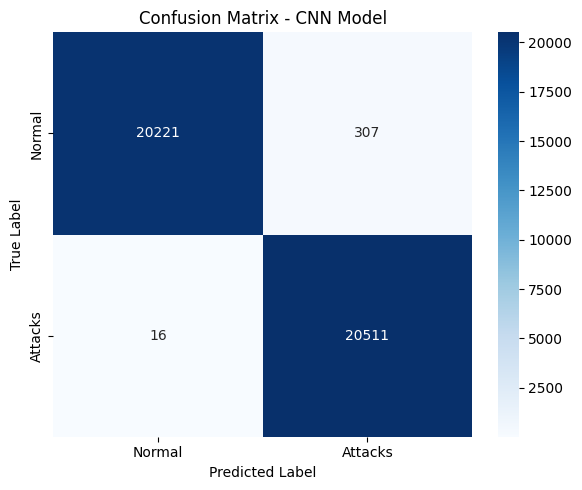

Attacks detected (True Positive) : 20511
Normal traffic detected (True Negative) : 20221
Attacks missed (False Negative) : 16
False alarms (False Positive) : 307


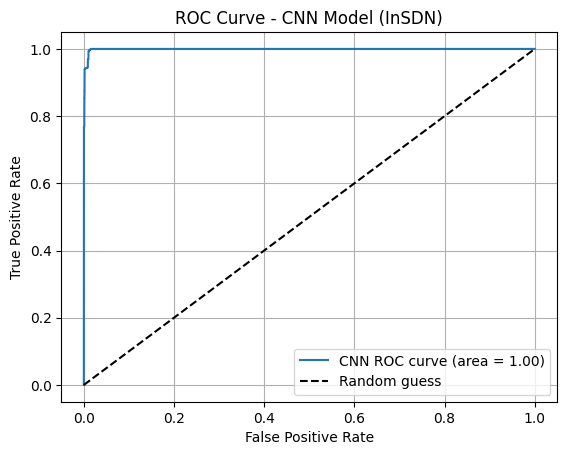

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/models/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/models/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### LSTM metrics

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     20528
     Attacks       0.98      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0388
Test Accuracy: 0.9903


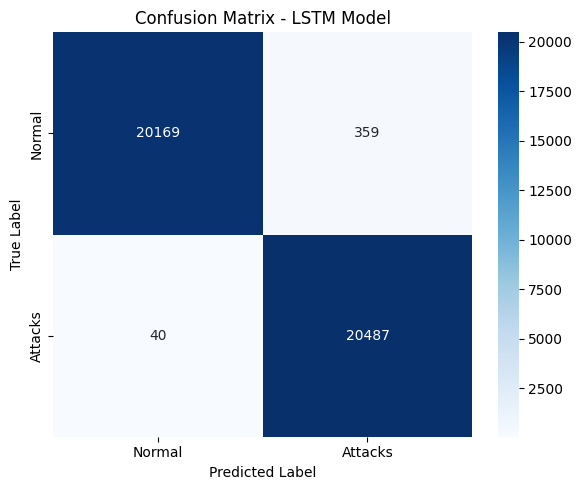

Attacks detected (True Positive) : 20487
Normal traffic detected (True Negative) : 20169
Attacks missed (False Negative) : 40
False alarms (False Positive) : 359


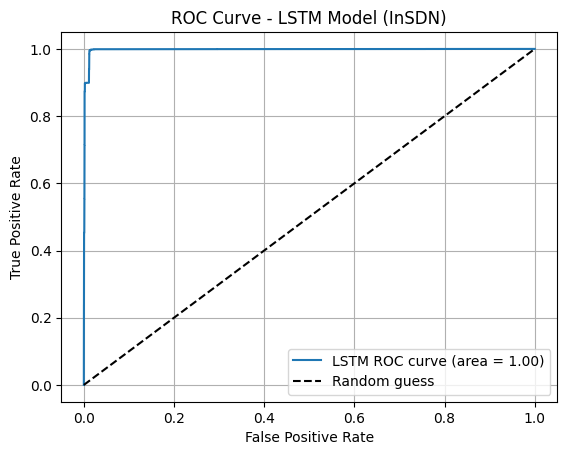

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/models/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/models/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### AE-LSTM metrics

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0348
Test Accuracy: 0.9913


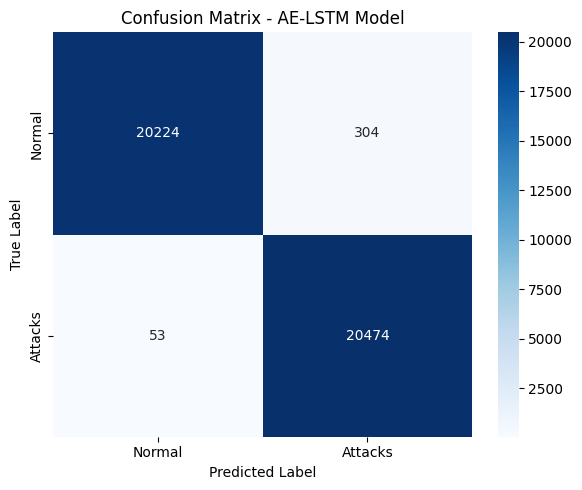

Attacks detected (True Positive) : 20474
Normal traffic detected (True Negative) : 20224
Attacks missed (False Negative) : 53
False alarms (False Positive) : 304


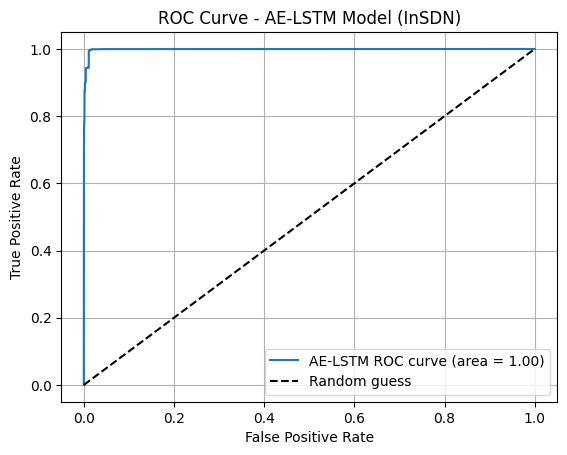

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = AE_LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/models/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/models/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
